In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import datetime as dt
import torch as torch
import matplotlib.pyplot as plt

import torch.nn as nn 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

from scipy.special import softmax

In [6]:
df = pd.read_csv('clean_data.csv')

In [7]:
df.head()

,Unnamed: 0,Brazil Open,Brazil High,Brazil Low,Brazil Close,Brazil Adj Close,Brazil Volume,Brazil Returns,Russia Open,Russia High,Russia Low,Russia Close,Russia Adj Close,Russia Volume,Russia Returns,India Open,India High,India Low,India Close,India Adj Close,India Volume,India Returns,China Open,China High,China Low,China Close,China Adj Close,China Volume,China Returns,South Africa Open,South Africa High,South Africa Low,South Africa Close,South Africa Adj Close,South Africa Volume,South Africa Returns,year,sin_day,cos_day,sin_day_of_week,cos_day_of_week,sin_month,cos_month,sin_week_of_year,cos_week_of_year
0,0,78.500000,79.370003,78.070000,79.220001,53.268791,1.606910e+07,0.022062,149.070007,150.550003,149.070007,150.550003,150.550003,1043.0,0.018675,10.477620,10.477620,10.477620,10.477620,10.477620,0.0,0.000995,52.580002,52.720001,52.529999,52.619999,42.883629,2900.000000,0.013873,3412.7334,3412.733400,3412.7334,3457.8498,3457.8498,1000.000000,0.028368,2011,0.258819,0.965926,-0.433884,-0.900969,1.0,6.123234e-17,1.000000,-1.608123e-16
1,1,78.846667,79.520002,78.390000,79.406667,53.394311,1.444657e+07,0.002356,150.013336,151.363337,150.013336,151.206670,151.206670,2127.0,0.004362,10.483197,10.483197,10.483197,10.483197,10.483197,0.0,0.000532,52.980001,53.073334,52.726666,52.993333,43.187885,5433.333333,0.007095,3430.2784,3434.580533,3430.2784,3463.5826,3463.5826,3599.666667,0.001658,2011,0.500000,0.866025,-0.974928,-0.222521,1.0,6.123234e-17,1.000000,-1.608123e-16
2,2,79.193334,79.670001,78.709999,79.593333,53.519831,1.282403e+07,0.002351,150.956665,152.176671,150.956665,151.863337,151.863337,3211.0,0.004343,10.488773,10.488773,10.488773,10.488773,10.488773,0.0,0.000532,53.380000,53.426666,52.923332,53.366668,43.492142,7966.666667,0.007045,3447.8234,3456.427667,3447.8234,3469.3154,3469.3154,6199.333333,0.001655,2011,0.707107,0.707107,-0.781831,0.623490,1.0,6.123234e-17,1.000000,-1.608123e-16
3,3,79.540001,79.820000,79.029999,79.779999,53.645351,1.120150e+07,0.002345,151.899994,152.990005,151.899994,152.520004,152.520004,4295.0,0.004324,10.494350,10.494350,10.494350,10.494350,10.494350,0.0,0.000532,53.779999,53.779999,53.119999,53.740002,43.796398,10500.000000,0.006996,3465.3684,3478.274800,3465.3684,3475.0482,3475.0482,8799.000000,0.001652,2011,0.866025,0.500000,0.000000,1.000000,1.0,6.123234e-17,0.992709,-1.205367e-01
4,4,79.449997,80.080002,79.230003,79.510002,53.463795,1.189970e+07,-0.003384,151.160004,152.160004,151.160004,152.160004,152.160004,8470.0,-0.002360,10.456600,10.456600,10.456600,10.456600,10.456600,0.0,-0.003597,53.500000,53.560001,53.400002,53.419998,43.535599,3700.000000,-0.005955,3477.7798,3477.779800,3477.7798,3477.7798,3477.7798,0.000000,0.000786,2011,0.965926,0.258819,0.781831,0.623490,1.0,6.123234e-17,0.992709,-1.205367e-01


In [8]:
df.drop(columns={'Unnamed: 0'}, inplace=True)

In [9]:
df.head()

,Brazil Open,Brazil High,Brazil Low,Brazil Close,Brazil Adj Close,Brazil Volume,Brazil Returns,Russia Open,Russia High,Russia Low,Russia Close,Russia Adj Close,Russia Volume,Russia Returns,India Open,India High,India Low,India Close,India Adj Close,India Volume,India Returns,China Open,China High,China Low,China Close,China Adj Close,China Volume,China Returns,South Africa Open,South Africa High,South Africa Low,South Africa Close,South Africa Adj Close,South Africa Volume,South Africa Returns,year,sin_day,cos_day,sin_day_of_week,cos_day_of_week,sin_month,cos_month,sin_week_of_year,cos_week_of_year
0,78.500000,79.370003,78.070000,79.220001,53.268791,1.606910e+07,0.022062,149.070007,150.550003,149.070007,150.550003,150.550003,1043.0,0.018675,10.477620,10.477620,10.477620,10.477620,10.477620,0.0,0.000995,52.580002,52.720001,52.529999,52.619999,42.883629,2900.000000,0.013873,3412.7334,3412.733400,3412.7334,3457.8498,3457.8498,1000.000000,0.028368,2011,0.258819,0.965926,-0.433884,-0.900969,1.0,6.123234e-17,1.000000,-1.608123e-16
1,78.846667,79.520002,78.390000,79.406667,53.394311,1.444657e+07,0.002356,150.013336,151.363337,150.013336,151.206670,151.206670,2127.0,0.004362,10.483197,10.483197,10.483197,10.483197,10.483197,0.0,0.000532,52.980001,53.073334,52.726666,52.993333,43.187885,5433.333333,0.007095,3430.2784,3434.580533,3430.2784,3463.5826,3463.5826,3599.666667,0.001658,2011,0.500000,0.866025,-0.974928,-0.222521,1.0,6.123234e-17,1.000000,-1.608123e-16
2,79.193334,79.670001,78.709999,79.593333,53.519831,1.282403e+07,0.002351,150.956665,152.176671,150.956665,151.863337,151.863337,3211.0,0.004343,10.488773,10.488773,10.488773,10.488773,10.488773,0.0,0.000532,53.380000,53.426666,52.923332,53.366668,43.492142,7966.666667,0.007045,3447.8234,3456.427667,3447.8234,3469.3154,3469.3154,6199.333333,0.001655,2011,0.707107,0.707107,-0.781831,0.623490,1.0,6.123234e-17,1.000000,-1.608123e-16
3,79.540001,79.820000,79.029999,79.779999,53.645351,1.120150e+07,0.002345,151.899994,152.990005,151.899994,152.520004,152.520004,4295.0,0.004324,10.494350,10.494350,10.494350,10.494350,10.494350,0.0,0.000532,53.779999,53.779999,53.119999,53.740002,43.796398,10500.000000,0.006996,3465.3684,3478.274800,3465.3684,3475.0482,3475.0482,8799.000000,0.001652,2011,0.866025,0.500000,0.000000,1.000000,1.0,6.123234e-17,0.992709,-1.205367e-01
4,79.449997,80.080002,79.230003,79.510002,53.463795,1.189970e+07,-0.003384,151.160004,152.160004,151.160004,152.160004,152.160004,8470.0,-0.002360,10.456600,10.456600,10.456600,10.456600,10.456600,0.0,-0.003597,53.500000,53.560001,53.400002,53.419998,43.535599,3700.000000,-0.005955,3477.7798,3477.779800,3477.7798,3477.7798,3477.7798,0.000000,0.000786,2011,0.965926,0.258819,0.781831,0.623490,1.0,6.123234e-17,0.992709,-1.205367e-01


In [8]:
def feature_label_split(df, target_cols):
    targets = [target for target in target_cols]
    y = df[targets]
    X = df.drop(columns=targets)
    return X, y

def train_val_test_split(df, target_cols, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_cols)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

returns = [returns for returns in df.columns if 'Returns' in returns] # unreal stuff, don't ask me how 
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df, returns, 0.2)

In [9]:
y_train

,Brazil Returns,Russia Returns,India Returns,China Returns,South Africa Returns
0,0.022062,0.018675,0.000995,0.013873,0.028368
1,0.002356,0.004362,0.000532,0.007095,0.001658
2,0.002351,0.004343,0.000532,0.007045,0.001655
3,0.002345,0.004324,0.000532,0.006996,0.001652
4,-0.003384,-0.002360,-0.003597,-0.005955,0.000786
...,...,...,...,...,...
2404,-0.011406,0.004094,0.004940,-0.002571,0.002153
2405,0.000249,-0.012957,-0.003214,0.009742,0.004382
2406,-0.006721,0.012812,-0.020878,0.006891,0.003056
2407,0.000000,-0.006118,-0.009533,0.001521,0.006476


In [10]:
scaler = MinMaxScaler()

X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

In [11]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [12]:
train_targets

tensor([[0.7362, 0.4679, 0.4970, 0.6123, 0.6899],
        [0.6579, 0.4117, 0.4943, 0.5690, 0.5185],
        [0.6579, 0.4116, 0.4943, 0.5687, 0.5185],
        ...,
        [0.6218, 0.4448, 0.3708, 0.5677, 0.5275],
        [0.6485, 0.3705, 0.4362, 0.5335, 0.5494],
        [0.5898, 0.3945, 0.5851, 0.5218, 0.4539]])

## LSTM

In [12]:
device = torch.device('cpu', 1)

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [14]:
def get_model(model, model_params):
    models = {
        "lstm": LSTMModel,
    }
    return models.get(model.lower())(**model_params)

In [15]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        # model_path = f'models/{self.model}_{dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}.pt'
        model_path = 'models/model.pt'
        
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader, batch_size=1, n_features=1):

        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

[1/100] Training loss: 0.1471	 Validation loss: 0.0644
[2/100] Training loss: 0.0095	 Validation loss: 0.0174
[3/100] Training loss: 0.0074	 Validation loss: 0.0121
[4/100] Training loss: 0.0067	 Validation loss: 0.0097
[5/100] Training loss: 0.0063	 Validation loss: 0.0083
[6/100] Training loss: 0.0061	 Validation loss: 0.0071
[7/100] Training loss: 0.0059	 Validation loss: 0.0063
[8/100] Training loss: 0.0057	 Validation loss: 0.0060
[9/100] Training loss: 0.0056	 Validation loss: 0.0051
[10/100] Training loss: 0.0054	 Validation loss: 0.0049
[50/100] Training loss: 0.0047	 Validation loss: 0.0045
[100/100] Training loss: 0.0047	 Validation loss: 0.0045


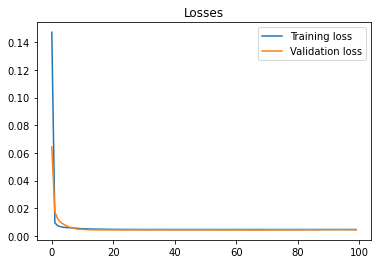

In [16]:
import torch.optim as optim

input_dim = len(X_train.columns)
output_dim = 5
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model('lstm', model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

lstm_predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

## Gradient Boosting

In [17]:
import xgboost as xgb

reg = xgb.XGBRegressor(
    tree_method="hist", 
    n_estimators=64)
    
clf = reg.fit(X_train_arr, y_train_arr)

In [18]:
xg_predictions = reg.predict(X_test_arr)

In [19]:
xg_predictions

array([[0.5851296 , 0.41117203, 0.47383857, 0.51966786, 0.47221434],
       [0.60827315, 0.37263748, 0.4183382 , 0.59554946, 0.40028507],
       [0.5982437 , 0.3779243 , 0.43675932, 0.58577263, 0.42589524],
       ...,
       [0.6800196 , 0.5518358 , 0.48310953, 0.6349142 , 0.52033705],
       [0.6728498 , 0.5437957 , 0.48335737, 0.6618716 , 0.5423358 ],
       [0.6658538 , 0.5452222 , 0.4622061 , 0.6377128 , 0.5501155 ]],
      dtype=float32)

## Transformers

In [13]:
import torch.nn.functional as F
from torch import nn, Tensor

In [21]:
# #TESTING 
# transformer_model = nn.Transformer(nhead=16, num_encoder_layers=12)

# src = torch.rand((32, 512, ))
# tgt = torch.rand((32, 512))
# out = transformer_model(src, tgt)

In [22]:
X_train_arr.shape, y_test_arr.shape

((2409, 39), (803, 5))

In [15]:
from typing import Tuple


def get_src_trg(
        sequence: torch.Tensor, 
        enc_seq_len: int, 
        target_seq_len: int
        ) -> Tuple[torch.tensor, torch.tensor, torch.tensor]:

        """
        Generate the src (encoder input), trg (decoder input) and trg_y (the target)
        sequences from a sequence. 
        Args:
            sequence: tensor, a 1D tensor of length n where 
                    n = encoder input length + target sequence length  
            enc_seq_len: int, the desired length of the input to the transformer encoder
            target_seq_len: int, the desired length of the target sequence (the 
                            one against which the model output is compared)
        Return: 
            src: tensor, 1D, used as input to the transformer model
            trg: tensor, 1D, used as input to the transformer model
            trg_y: tensor, 1D, the target sequence against which the model output
                is compared when computing loss. 
        
        """

        assert len(sequence) == enc_seq_len + target_seq_len, "Sequence length does not equal (input length + target length)"
        
        #print("From data.TransformerDataset.get_src_trg: sequence shape: {}".format(sequence.shape))

        # encoder input
        src = sequence[:enc_seq_len] 
        
        # decoder input. As per the paper, it must have the same dimension as the 
        # target sequence, and it must contain the last value of src, and all
        # values of trg_y except the last (i.e. it must be shifted right by 1)
        trg = sequence[enc_seq_len-1:len(sequence)-1]

        # trg = trg[:, 0] 

        if len(trg.shape) == 1:
            trg = trg.unsqueeze(-1)
        
        assert len(trg) == target_seq_len, "Length of trg does not match target sequence length"

        # The target sequence against which the model output will be compared to compute loss
        trg_y = sequence[-target_seq_len:,-5:]

        #print("From data.TransformerDataset.get_src_trg: trg_y shape before slice: {}".format(trg_y.shape))

        # We only want trg_y to consist of the target variable not any potential exogenous variables
        # trg_y = trg_y[:, 0]

        assert len(trg_y) == target_seq_len, "Length of trg_y does not match target sequence length"

        return src, trg, trg_y # change size from [batch_size, target_seq_len, num_features] to [batch_size, target_seq_len] 

In [16]:
X_train_arr.shape, X_test_arr.shape

((2409, 39), (803, 39))

In [17]:
train_data = np.hstack((X_train_arr, y_train_arr))
test_data = np.hstack((X_test_arr, y_test_arr))

sequence = np.vstack((train_data, test_data))
sequence = torch.tensor(sequence, dtype=torch.float32)

enc_seq_len = len(y_train_arr)
target_seq_len = len(y_test_arr)

src, trg, trg_y = get_src_trg(sequence, enc_seq_len, target_seq_len)

In [18]:
src.shape, trg.shape, trg_y.shape

(torch.Size([2409, 44]), torch.Size([803, 44]), torch.Size([803, 5]))

In [27]:
src.size(-1), trg.size(-1)

(44, 44)

In [28]:
transformer_model = nn.Transformer(d_model = 44, nhead = 22, num_encoder_layers=12)

out = transformer_model(src, trg)
transformer_predictions = out.detach().numpy()[:, -5:] # we just need the final 5 cols for the returns 

In [29]:
# transformer_model = nn.Transformer(d_model = 44, nhead=11, num_encoder_layers=12)
# src = torch.rand((2409, 44))
# tgt = torch.rand((803, 44))
# out = transformer_model(src, tgt)

## Temporal Fusion Transformer

In [1]:
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

In [2]:
from pytorch_forecasting.data.examples import get_stallion_data

data = get_stallion_data()

# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")

NameError: name 'np' is not defined

In [6]:
data.columns

Index(['agency', 'sku', 'volume', 'date', 'industry_volume', 'soda_volume',
       'avg_max_temp', 'price_regular', 'price_actual', 'discount',
       'avg_population_2017', 'avg_yearly_household_income_2017', 'easter_day',
       'good_friday', 'new_year', 'christmas', 'labor_day', 'independence_day',
       'revolution_day_memorial', 'regional_games', 'fifa_u_17_world_cup',
       'football_gold_cup', 'beer_capital', 'music_fest',
       'discount_in_percent', 'timeseries', 'time_idx', 'month', 'log_volume',
       'avg_volume_by_sku', 'avg_volume_by_agency'],
      dtype='object')

In [ ]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = df["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

## Analysis of Results

In [30]:
def depict_results(predictions):
    
    arr = []
    for prediction in predictions:
        arr.append(prediction.flatten())

    predictions = np.array(arr)
    predicted = scaler.inverse_transform(predictions) 

    df_predicted = pd.DataFrame(predicted, 
                columns=['Brazil Returns',
                'Russia Returns',
                'India Returns', 
                'China Returns',
                'South Africa Returns'])

    return df_predicted

In [31]:
# predictions
lstm_df = depict_results(lstm_predictions)
xg_df = depict_results(xg_predictions)
transformer_df = depict_results(transformer_predictions)

In [2]:
lstm_df.to_csv('lstm_results.csv')
xg_df.to_csv('xg_results.csv')
transformer_df.to_csv('transformer_results.csv')

NameError: name 'lstm_df' is not defined

In [1]:
lstm_df

NameError: name 'lstm_df' is not defined

In [44]:
lstm_df.drop(columns='Unnamed: 0', inplace=True)
xg_df.drop(columns='Unnamed: 0', inplace=True)
transformer_df.drop(columns='Unnamed: 0', inplace=True)

In [45]:
lstm_mae = mean_absolute_error(lstm_df, y_test)
xg_mae = mean_absolute_error(xg_df, y_test)
transformer_mae = mean_absolute_error(transformer_df, y_test)

In [46]:
lstm_mae, xg_mae, transformer_mae

(0.012295575133412848, 0.01926163054190369, 0.08135306997088222)

In [47]:
lstm_mse = mean_squared_error(lstm_df, y_test)
xg_mse = mean_squared_error(xg_df, y_test)
transformer_mse = mean_squared_error(transformer_df, y_test)

In [48]:
lstm_mse, xg_mse, transformer_mse

(0.0005884616188611248, 0.000937936838406417, 0.011095821232349866)

In [56]:
lstm_results_arr = lstm_df.to_numpy().flatten()
y_test_arr = y_test_arr.flatten()

In [57]:
y_test_arr.shape, lstm_results_arr.shape

((4015,), (4015,))

In [59]:
def max_drawdown(df, window=252):
    
    roll_max = df['Close'].rolling(window, min_periods=1).max()
    daily_drawdown = df['Close']/roll_max - 1.0

    max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

    return max_daily_drawdown